# Results for the multi-demand dataset

In [1]:
import os
import numpy as np
import pandas as pd
import nitools as nt
from pathlib import Path
import matplotlib.pyplot as plt

import selective_recruitment.plotting as plotting
import selective_recruitment.recruite_ana as ra
import selective_recruitment.globals as gl
import selective_recruitment.scripts.script_prep_sc as ss

from statsmodels.stats.anova import AnovaRM # perform F test

In [2]:
# setting working directory 
wkdir = '/Volumes/diedrichsen_data$/data/Cerebellum/Demand/selective_recruit'
if not Path(wkdir).exists():
    wkdir = '/srv/diedrichsen/data/Cerebellum/Demand/selective_recruit'

## 1. Plots and test results
Scatterplot using regression

In [15]:
# Generate the labels and colors for all scatterplot
label_dict={1:'NbEFace', 2:'NBEHouse',
            3:'NbHFace', 4:'NbHHouse',
            5:'SwEFace', 6:'SwEHouse',
            7:'SwHFace', 8:'SwHHouse',
            9:'StEFace', 10:'StEHouse',
            11:'StHFace',12:'StHHouse',
            13:'rest'}
marker_dict = {1:'o',2:'X',
                3:'o',4:'X',
                5:'o',6:'X',
                7:'o',8:'X',
                9:'o',10:'X',
                11:'o',12:'X',
                13:'s'}
color_dict  = {1:'b',2:'b',
                3:'r',4:'r',
                5:'b',6:'b',
                7:'r',8:'r',
                9:'b',10:'b',
                11:'r',12:'r',
                13:'g'}

### 1.1 Over the whole cerebellum and cortex

Prepare data and run regression 
This way the functions are universal across projects, and it transparent where 
the files / ROIs come from and how the tsv-file is produced. 

Given that get_summary and run_regress are shared basic functions, 
the loading saving of files is done outside of the functions - makes things clearer

In [4]:
D = ra.get_summary(dataset = "Demand", 
                ses_id = 'ses-01', 
                type = "CondAll", 
                cerebellum_roi = None, 
                cortex_roi = None,
                add_rest = True)
D = ra.run_regress(D,fit_intercept=True)
D.to_csv(wkdir + '/ROI_all.tsv',sep='\t')


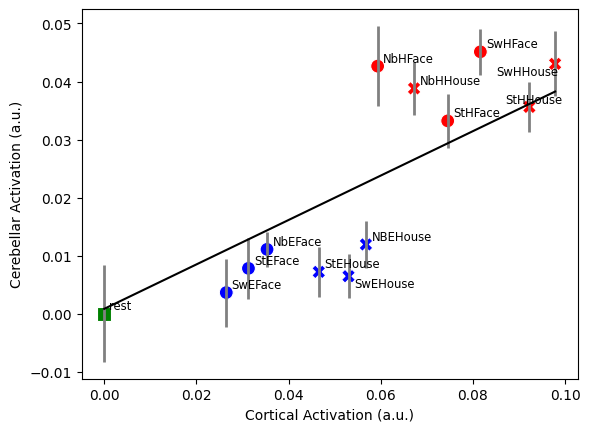

In [17]:
df_path = os.path.join(wkdir, "ROI_all.tsv")
df1 = pd.read_csv(df_path, sep="\t")
plotting.make_scatterplot(df1,split='reg_id',
            labels=label_dict,
            markers=marker_dict,
            colors=color_dict)

Figure 1. Scatterplot showing average cerebellar activation in each condition vs the corresponding average activation in the cortex. The linear fit is shown in grey. Error bars represent the 95% confidence interval on the residuals of the linear regression fit (within each subject). 

<font color = 'grey'> Do F-test (repeated measures ANOVA)

In [18]:
# need to pass 
print(AnovaRM(data=df1[df1.cond_name!='rest'], depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                  Anova
          F Value  Num DF  Den DF  Pr > F
-----------------------------------------
cond_name 16.0825 11.0000 396.0000 0.0000



### 1.2 Over region of interests
#### 1.2.1 verbal working memory contrast

<font color = 'grey'>Prepare the dataframe for the scatterplot

In [19]:
D = ra.get_summary(dataset = "Demand", 
                ses_id = 'ses-01', 
                type = "CondAll", 
                cerebellum_roi ='tpl-SUIT/atl-Verbal2Back_space-SUIT', 
                cortex_roi = "tpl-fs32k/Verbal2Back.32k",
                add_rest = True)
D = ra.run_regress(D,fit_intercept=True)
D.to_csv(wkdir + '/ROI_Verbal2Back.tsv',sep='\t')

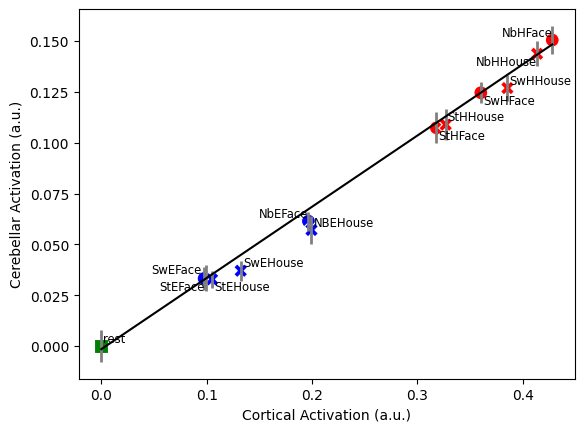

In [20]:
df_path = os.path.join(wkdir, "ROI_Verbal2Back.tsv")
df2 = pd.read_csv(df_path, sep="\t")
plotting.make_scatterplot(df2,split='reg_id',
            labels=label_dict,
            markers=marker_dict,
            colors=color_dict)

<font color = 'grey'> Do F-test (repeated measures ANOVA)

In [21]:
print(AnovaRM(data=df2[df2.cond_name!='rest'], depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                  Anova
          F Value  Num DF  Den DF  Pr > F
-----------------------------------------
cond_name  1.9220 11.0000 396.0000 0.0352



### 1.3 Using connectivity models
Connectivity weights will be used to make predictions for a specific ROI 

<font color = 'grey'> Model trained on MDTB, tested on MDTB:<br>

#### 1.3.1 MDTB10 parcellation

In [22]:
D = ss.get_summary_conn(dataset = "Demand", 
                    ses_id = 'ses-01', 
                    type = "CondHalf", 
                    cerebellum_roi ='MDTB10', 
                    cortex_roi = "Icosahedron-1002_Sym.32k",
                    add_rest = True)
D = ra.run_regress(D,fit_intercept=True)
D.to_csv(wkdir + '/ROI_MDTB10_conn.tsv',sep='\t')

/home/ROBARTS/lshahsha/Documents/Projects/Functional_Fusion/dataset.py:171: RuntimeWarning: Mean of empty slice
  parcel_data[..., i] = fcn(


In [23]:
df_path = os.path.join(wkdir, "ROI_MDTB10_conn.tsv")
df3 = pd.read_csv(df_path, sep="\t")

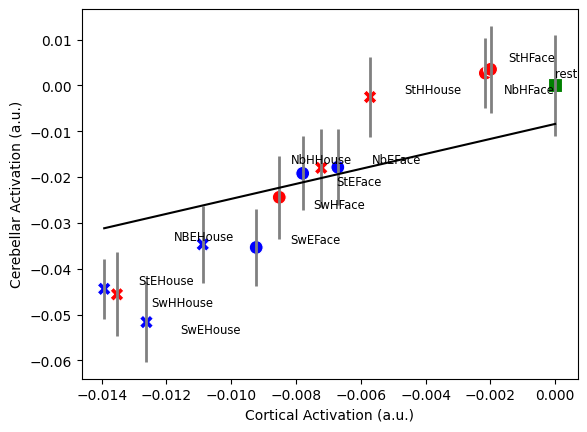

In [25]:
# select an roi to make the plot
roi_num = 6
plotting.make_scatterplot(df3.loc[df3.roi == roi_num],split='reg_id',
            labels=label_dict,
            markers=marker_dict,
            colors=color_dict)

In [26]:
print(AnovaRM(data=df3[df3.cond_name!='rest'][df3.roi == roi_num], depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                  Anova
          F Value  Num DF  Den DF  Pr > F
-----------------------------------------
cond_name  7.9630 11.0000 396.0000 0.0000



/tmp/ipykernel_48394/2405680126.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(AnovaRM(data=df3[df3.cond_name!='rest'][df3.roi == roi_num], depvar='res',


#### 1.3.1 Hierarchical symmetric parcellation

In [27]:
D = ss.get_summary_conn(dataset = "Demand", 
                    ses_id = 'ses-01', 
                    type = "CondHalf", 
                    cerebellum_roi ='NettekovenSym34', 
                    cortex_roi = "Icosahedron-1002_Sym.32k",
                    add_rest = True)
D = ra.run_regress(D,fit_intercept=True)
D.to_csv(wkdir + '/ROI_NettekovenSym34_conn.tsv',sep='\t')

/home/ROBARTS/lshahsha/Documents/Projects/Functional_Fusion/dataset.py:171: RuntimeWarning: Mean of empty slice
  parcel_data[..., i] = fcn(


In [28]:
df_path = os.path.join(wkdir, "ROI_NettekovenSym34_conn.tsv")
df4 = pd.read_csv(df_path, sep="\t")

In [29]:
# get parcel names
# read the lut file
lut = nt.read_lut(gl.atlas_dir + '/tpl-SUIT/atl-NettekovenSym34.lut')
# get the label info
label_info = lut[2]

'0'

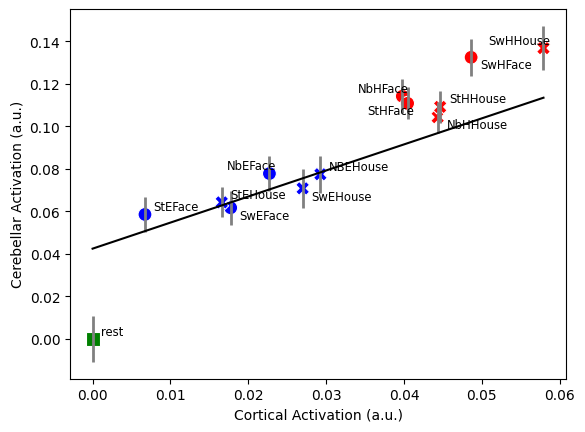

In [32]:
# select an roi to make the plot
## test these parcels: "O1L", "O1R", "W1R", "W1L", "W4L", "W4R", "M3R", "M3L"
roi_num = label_info.index("M3R")
plotting.make_scatterplot(df4.loc[df4.roi == roi_num],split='reg_id',
            labels=label_dict,
            markers=marker_dict,
            colors=color_dict)

plt.xlabel("predicted cerebellar activation")

In [33]:
print(AnovaRM(data=df4[df4.cond_name!='rest'][df4.roi == roi_num], depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                  Anova
          F Value  Num DF  Den DF  Pr > F
-----------------------------------------
cond_name  8.1037 11.0000 396.0000 0.0000



/tmp/ipykernel_48394/1108005144.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(AnovaRM(data=df4[df4.cond_name!='rest'][df4.roi == roi_num], depvar='res',


#### 1.3.2 Hierarchical symmetric parcellation (32 parcels)

In [ ]:
D = ss.get_summary_conn(dataset = "Demand", 
                    ses_id = 'ses-01', 
                    type = "CondHalf", 
                    cerebellum_roi ='NettekovenSym68c32', 
                    cortex_roi = "Icosahedron-1002_Sym.32k",
                    add_rest = True)
D = ra.run_regress(D,fit_intercept=True)
D.to_csv(wkdir + '/ROI_NettekovenSym68c32_conn.tsv',sep='\t')

In [ ]:
df_path = os.path.join(wkdir, "ROI_NettekovenSym68c32_conn.tsv")
df5 = pd.read_csv(df_path, sep="\t")

In [ ]:
# load in the lut file to get the roi names
lut = nt.read_lut(gl.atlas_dir + '/tpl-SUIT/atl-NettekovenSym68c32.lut')
# get the label info
label_info = lut[2]
# label_info

In [ ]:
# select an roi to make the plot
## test these parcels: "O1L", "O1R", "W1R", "W1L", "W4L", "W4R", "M3R", "M3L"
roi_num = label_info.index("M3R")
plotting.make_scatterplot(df5.loc[df5.roi == roi_num],split='reg_id',
            labels=label_dict,
            markers=marker_dict,
            colors=color_dict)
plt.xlabel("predicted cerebellar activation")